<a href="https://colab.research.google.com/github/Bonorinoa/LangGraph-Crash-Course/blob/main/Lesson_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install langgraph langsmith langchain_groq langchain_core langchain_community --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.1 MB/s eta 0:00:00


## Introduction to LangGraph

If you've ever tried to build something with an LLM, or at least have been keeping up with the field, you've probably heard of [LangChain](https://python.langchain.com/docs/introduction/). Harrison Chase first launched it in October 2022 as an open-source tool for orchestrating LLM-based applications. It was a huge success, and just months after its initial release, the team secured millions of dollars to continue developing the module.

At its core, LangChain is a tool for creating [Directed Acyclic Graphs (DAG)](https://es.wikipedia.org/wiki/Grafo_ac%C3%ADclico_dirigido) where nodes are powered by LLMs and are sequentially "chained". The key property of a DAG is that it has no cycles or loops. Given a query, it will pass information sequentially to all nodes. Routing is allowed, but there's no way to return to a previous node once executed. It facilitates the development of structured workflows, what I call "recipes", like [Retrieval-Augmented Generation (RAG)](https://medium.com/@agbonorino/a-recipe-for-your-custom-rag-application-256137bc3ddc) chatbots. But it doesn't provide the autonomy and loop mechanisms that AI Agents promise to offer. LangGraph is their solution to this limitation.

Inspired by the Python graph visualization package [NetworkX](https://www.bing.com/search?q=networkx&cvid=7eb500aabf7444cc92118e82ea499cc3&gs_lcrp=EgRlZGdlKgYIABBFGDkyBggAEEUYOTIGCAEQABhAMgYIAhAAGEAyBggDEAAYQDIGCAQQABhAMgYIBRAAGEAyBggGEAAYQDIGCAcQABhAMgYICBAAGEDSAQgzMDk0ajBqNKgCALACAA&FORM=ANAB01&PC=SCOOBE), this framework facilitates the development of cyclic and stateful workflows with built-in persistence features to incorporate memory. It differs from other frameworks like [CrewAI](https://www.crewai.com/), [AutoGen](https://github.com/microsoft/autogen) or [MetaGPT](https://github.com/geekan/MetaGPT) by providing low-level control over the creation of Agent workflows. That is, you can build your workflows from scratch instead of having to rely on predefined Agents. The obvious downside is a steeper learning curve. But, everything in life is a trade-off. I hope this article guides you in the right direction and saves you valuable hours of your time.

### Fundamentals

There are three fundamental building blocks for any LangGraph Agent workflow:

- **State**: A dictionary or named data structure (e.g., Pydantic BaseModel or a typing TypedDict object) that stores data that needs to be maintained throughout the graph. It's available to all nodes and there can be multiple States to define [multiple schemas](https://langchain-ai.github.io/langgraph/concepts/low_level/#multiple-schemas).
    - Importantly, all states typically implement a [reducer](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) that defines how updates will be incorporated (e.g., adding to a list of messages to dynamically build a chat history or simply overwriting the current value).

- **Nodes**: The Building Blocks of Work: Each node in a LangGraph represents a distinct unit of work or action within the application. Each node is a Python function or a [LangChain Runnable](https://python.langchain.com/docs/concepts/runnables/) that performs operations to update the State. It generally takes a State object and returns an update to the State. This task could involve a variety of operations, such as:
    - Direct communication with an LLM for text generation, summarization, or other language-based tasks.
    - Interaction with external tools and APIs to fetch data or perform real-world actions. In this case, we'll refer to the node as a "tool".
    - Data manipulation through processes like formatting, filtering, or transformation.
    - User interaction to gather information or display data.

- **Edges**: Guiding Information Flow and Control: Edges serve as the connective tissue within a LangGraph, establishing paths for information flow between nodes and dictating the sequence of operations. LangGraph supports multiple types of edges:

    - ***Simple Edges***: These denote a direct and unconditional flow from one node to another. The output of the first node feeds as input to the next node, creating a linear progression.

    - ***Conditional Edges***: Introducing a layer of dynamism, conditional edges allow the workflow to branch based on the outcome of a specific node's operation. These enable the cyclic feature we discussed; a function will continue to be called until a condition is met.


In [ ]:
from langgraph.graph import Graph, StateGraph, START, END
from langchain_groq import ChatGroq

from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage # message abstraction
import operator

import os, getpass
from IPython.display import Image, display

# utility to visualize the workflow created
def visualize_workflow(workflow):
    display(Image(workflow.get_graph().draw_mermaid_png()))

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

GROQ_API_KEY: ··········


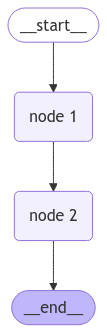

In [ ]:
# stateless graph
def node1(msg: str) -> str:
    'Function to upper case the string'
    return msg.upper()

def node2(msg2: str) -> str:
    'Function to add a string to the upper cased message'
    return msg2 + " end of node"

graph = Graph()
graph.add_node("node 1", node1)
graph.add_node("node 2", node2)

graph.add_edge(START, "node 1")
graph.add_edge("node 1", "node 2")
graph.add_edge("node 2", END)

workflow = graph.compile()
visualize_workflow(workflow)

In [ ]:
workflow.invoke("Hello World")

'HELLO WORLD end of node'

In [ ]:
for chunk in workflow.stream("Hello World"):
    print(chunk)

{'node 1': 'HELLO WORLD'}
{'node 2': 'HELLO WORLD end of node'}


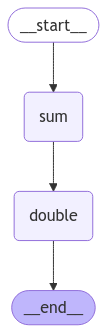

In [ ]:
# simple state
state = {
    "a": 0,
    "b": 0,
    "total": 0
}

def sum(state: dict) -> dict:
    'Function to add a + b from the state and update total'
    state['total'] = state['a'] + state['b']
    return state

def double(state: dict) -> dict:
    'Function to double total from state'
    state['total'] = state['total'] * 2
    return state

graph = Graph()

graph.add_node("sum", sum)
graph.add_node("double", double)

graph.add_edge(START, "sum")
graph.add_edge("sum", "double")
graph.add_edge("double", END)

workflow = graph.compile()
visualize_workflow(workflow)

In [ ]:
for chunk in workflow.stream({"a": 1, "b": 2}):
    print(chunk)

{'sum': {'a': 1, 'b': 2, 'total': 3}}
{'double': {'a': 1, 'b': 2, 'total': 6}}


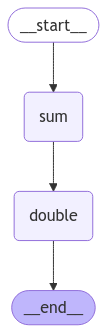

In [ ]:
# object oriented State (TypedDict)
class AgentState(TypedDict):
    a: int
    b: int
    total: int

def sum(state: AgentState) -> dict:
    'Function to add a + b from the state and update total'
    # now we can update the state directly rather then returning the entire dictionary
    return {'total': state['a'] + state['b']}

def double(state: AgentState) -> dict:
    'Function to double total from state'
    return {'total': state['total'] * 2}

graph = StateGraph(AgentState)

graph.add_node("sum", sum)
graph.add_node("double", double)

graph.add_edge(START, "sum")
graph.add_edge("sum", "double")
graph.add_edge("double", END)

workflow = graph.compile()
visualize_workflow(workflow)

In [ ]:
# more on streaming -> https://langchain-ai.github.io/langgraph/concepts/streaming/?h=stream
for chunk in workflow.stream({"a": 1, "b": 2, "total": 0}, stream_mode="values"):
    print(chunk)

{'a': 1, 'b': 2, 'total': 0}
{'a': 1, 'b': 2, 'total': 3}
{'a': 1, 'b': 2, 'total': 6}


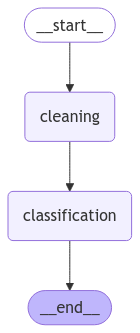

In [ ]:
# Simple Graph with LLM
llama3_1 = ChatGroq(model_name="llama-3.1-8b-instant",
                    temperature=0)

class SentimentState(TypedDict):
    review: str
    sentiment: str

def clean_str(state: SentimentState) -> SentimentState:
    'Function to clean the string'
    return {'review': state['review'].strip()}

def classify_sentiment(state: SentimentState) -> SentimentState:
    'Function to classify sentiment'

    en_prompt = "Classify the following review into positive, negative, or neutral. If there are more than one review, return a classification for each one.\n\n" + state['review'] + ""
    #es_prompt = "Clasifica la siguiente reseña en positivo, negativo o neutral. Si hay más de una reseña, devuelve una clasificación individual para cada una.\n\n " + state['review'] + ""
    sentiment = llama3_1.invoke(en_prompt).content
    return {'sentiment': sentiment}

graph = StateGraph(SentimentState)

graph.add_node("cleaning", clean_str)
graph.add_node("classification", classify_sentiment)

graph.add_edge(START, "cleaning")
graph.add_edge("cleaning", "classification")
graph.add_edge("classification", END)

workflow = graph.compile()
visualize_workflow(workflow)


In [ ]:
for chunk in workflow.stream({"review": "Me encanto este producto!", "sentiment": ""}, stream_mode="values"):
    print(chunk)

{'review': 'Me encanto este producto!', 'sentiment': ''}
{'review': 'Me encanto este producto!', 'sentiment': ''}
{'review': 'Me encanto este producto!', 'sentiment': 'This review is classified as: Positive\n\nTranslation: "I loved this product!"'}


In [ ]:
# Nowadays LLMs generalize well enough to be able to deal with multiple languages simultaneously out of the box
for chunk in workflow.stream({"review": "1. This is a great product! 2. El curso no satisface mis expectativas", "sentiment": ""}, stream_mode="values"):
    print(chunk)

{'review': '1. This is a great product! 2. El curso no satisface mis expectativas', 'sentiment': ''}
{'review': '1. This is a great product! 2. El curso no satisface mis expectativas', 'sentiment': ''}
{'review': '1. This is a great product! 2. El curso no satisface mis expectativas', 'sentiment': 'Based on the given reviews, here are the classifications:\n\n1. Positive: The first review says "This is a great product!" which is a clear expression of satisfaction and approval.\n2. Negative: The second review says "El curso no satisface mis expectativas" which translates to "The course does not meet my expectations." This is a negative statement indicating dissatisfaction.'}


In [ ]:
final_answer = workflow.invoke({"review": "1. This is a great product! 2. El curso no satisface mis expectativas", "sentiment": ""})
print(final_answer['sentiment'])

Based on the given reviews, here are the classifications:

1. Positive: The first review states "This is a great product!" which is a clear expression of satisfaction and approval.
2. Negative: The second review states "El curso no satisface mis expectativas" which translates to "The course does not meet my expectations." This is a negative statement indicating dissatisfaction.


Quick recap. We've seen the basic components of any langgraph workflow, which are: 1) A Graph (set of nodes and edges), and 2) a State (TypedDict or Python Pydantic class). We can use graphs without any State. However, if we want to have specific pieces of information available at any point in the workflow (whether it's context for an LLM or inputs for a function), then State is essential to define a data schema.

So far, we've only considered linear workflows. An input is provided at the START node and operations are applied sequentially. In reality, most interesting problems aren't linear. This is where LangGraph truly shines, allowing us to set up cyclic workflows to iterate based on specific criteria. The building block for unlocking these applications is the conditional edge, the focus of this notebook.

To create this edge, you need to provide three things:

- **The upstream node**: the output of this node will be analyzed to determine what to do next
- **A function**: this will be called to determine which node to call next. It must return a string
- **A mapping**: this mapping will be used to assign the output of the function in (2) to another node. The keys must be possible values that the function in (2) could return. The values must be node names to go to if that value is returned.

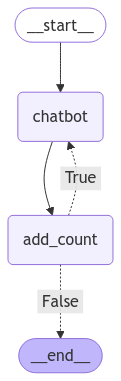

In [ ]:
# Messages state with conditional edges
class ChatbotState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    counter: int

def chatbot(state: ChatbotState) -> ChatbotState:
    'Function to generate a message with the LLM'
    en_prompt = f"Generate a short joke that rhymes with the following number: {state['counter']}"
    # es_prompt = f"Genera un chiste corto que rime con el siguiente numero: {state['counter']}"

    # the reducer "operator.add" allows us to pass a list of BaseMessage objects and update the key "messages"
    # it is very similar to the .extend() operation of a Python list
    new_message = [llama3_1.invoke(en_prompt).content]
    return {'messages': new_message}

def add_count(state: ChatbotState) -> ChatbotState:
    "Function to update the counter"
    return {'counter': state['counter'] + 1}

# Let's add a decision node
def nodo_decision(state: ChatbotState) -> bool:
    "Function to determine if cycle should end"
    return state['counter'] < 5

graph = StateGraph(ChatbotState)

graph.add_node("chatbot", chatbot)
graph.add_node("add_count", add_count)

graph.add_edge(START, "chatbot")
graph.add_edge("chatbot", "add_count")
graph.add_conditional_edges("add_count", # upstream node: here is where the conditional edge starts
                           nodo_decision, # python function to determine the routing decision
                           { # map the decision funtion's output to the desired nodes
                               True: "chatbot",
                               False: END
                           } # In this case, if counter < 5 we return to "chatbot", otherwise the the cycle ends.
                            )

workflow = graph.compile()
visualize_workflow(workflow)

In [ ]:
for chunk in workflow.stream({"messages": [], "counter": 0}, stream_mode="values"):
    print(chunk)

{'messages': [], 'counter': 0}
{'messages': ['Here\'s a short joke that rhymes with "0":\n\nWhy did the zero go to the show?\nBecause it was a "go" and wanted to know.'], 'counter': 0}
{'messages': ['Here\'s a short joke that rhymes with "0":\n\nWhy did the zero go to the show?\nBecause it was a "go" and wanted to know.'], 'counter': 1}
{'messages': ['Here\'s a short joke that rhymes with "0":\n\nWhy did the zero go to the show?\nBecause it was a "go" and wanted to know.', 'Why was the sun in a spin? \nIt was number 1, the only one within.'], 'counter': 1}
{'messages': ['Here\'s a short joke that rhymes with "0":\n\nWhy did the zero go to the show?\nBecause it was a "go" and wanted to know.', 'Why was the sun in a spin? \nIt was number 1, the only one within.'], 'counter': 2}
{'messages': ['Here\'s a short joke that rhymes with "0":\n\nWhy did the zero go to the show?\nBecause it was a "go" and wanted to know.', 'Why was the sun in a spin? \nIt was number 1, the only one within.', 'Why

In [ ]:
final_answer = workflow.invoke({"messages": [], "counter": 0})['messages']

for i, msg in enumerate(final_answer):
    print(f"\n---- Joke # {i} ----\n")
    print(msg)


---- Joke # 0 ----

Here's a short joke that rhymes with "0":

Why did the zero go to the show?
Because it was a "go" and wanted to know.

---- Joke # 1 ----

Why was the sun in a spin? 
It was number 1, the only one within.

---- Joke # 2 ----

Why was the math book sad after losing a clue? 
Because it had a problem that was true.

---- Joke # 3 ----

Here's a short joke that rhymes with the number 3:

Why did the cat join a band at sea?
Because it wanted to be a purr-cussionist with glee.

---- Joke # 4 ----

Here's a short joke that rhymes with the number 4:

Why did the cat join a band at the door?
Because it wanted to be the purr-cussionist for sure.


LLMs still need a bit of work on the humor side 😅

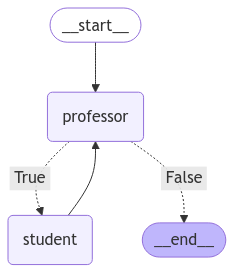

In [ ]:
# the last example
# MessagesState with conditional edges
## Chatbots are the most common applications, and they all require monitoring a chat history to take into account previous context
## Our ChatbotState essentially fulfills this function with the list of messages `messages` and the reducer operator.add
## Given the common usage, LangGraph provides a state with these characteristics to save a bit of time and code

from langgraph.graph import MessagesState

def professor(state: MessagesState) -> MessagesState:
    "Function to generate a response to a student's question"

    prompt = "You are a detailed and professional Austrian economics professor." \
            + f"Please provide a concise but complete answer to the following question:\n\n{state['messages'][-1]}"

    nuevo_mensaje = [llama3_1.invoke(prompt).content]

    return {'messages': nuevo_mensaje}

def student(state: MessagesState) -> MessagesState:
    "Function to generate a reaction and a question to the professor's answer"

    prompt = "You are a curious and intelligent university economics student." \
            + f"Provide a question for the following answer:\n\n{state['messages'][-1]}"
    nuevo_mensaje = [llama3_1.invoke(prompt).content]

    return {'messages': nuevo_mensaje}

def decision_node(state: MessagesState) -> bool:
    "Function to determine if graph should end"
    if len(state['messages']) <= 6:
        return True
    else:
        return False

graph = StateGraph(MessagesState)

graph.add_node("professor", professor)
graph.add_node("student", student)

graph.add_edge(START, "professor")
graph.add_edge("student", "professor")
graph.add_conditional_edges("professor",
                            decision_node,
                            {
                                True: "student",
                                False: END
                            })

workflow = graph.compile()
visualize_workflow(workflow)

In [ ]:
from langchain_core.messages import HumanMessage

chat_init = {'messages': [HumanMessage("What is the meaning of price?")]}

for chunk in workflow.stream(chat_init, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='What is the meaning of price?', additional_kwargs={}, response_metadata={}, id='c50b74a0-1a61-41f0-9a67-d2f7b575027b')]}
{'messages': [HumanMessage(content='What is the meaning of price?', additional_kwargs={}, response_metadata={}, id='c50b74a0-1a61-41f0-9a67-d2f7b575027b'), HumanMessage(content="As an Austrian economics professor, I'd be delighted to provide a comprehensive explanation of the concept of price.\n\n**The Meaning of Price**\n\nIn economics, price is a fundamental concept that represents the amount of money exchanged for a good or service in a market transaction. It is a crucial mechanism that facilitates the allocation of resources, coordinates the actions of buyers and sellers, and reflects the relative scarcity of goods and services.\n\n**Key Characteristics of Price**\n\n1. **Relative Value**: Price is a relative concept, meaning it is determined by the interaction of supply and demand in a market. It reflects the relative value of

In [ ]:
from textwrap import TextWrapper
wrapper = TextWrapper(width=120) # utility to format text and keep it within the console's margins

final_answer = workflow.invoke(chat_init)['messages']

for i, msg in enumerate(final_answer):
    print(f"\n---- Answer # {i} ----\n")
    paragraphs = msg.content.splitlines()  # to maintain the string's format (paragraphs, etc.)
    wrapped_text = "\n".join([wrapper.fill(p) for p in paragraphs])
    print(wrapped_text)


---- Answer # 0 ----

What is the meaning of price?

---- Answer # 1 ----

As an Austrian economics professor, I'd be delighted to provide a comprehensive explanation of the concept of price.

**The Meaning of Price**

In economics, price is a fundamental concept that represents the amount of money exchanged for a good or service in a
market transaction. It is a crucial mechanism that facilitates the allocation of resources, coordinates the actions of
buyers and sellers, and reflects the relative scarcity of goods and services.

**Key Characteristics of Price**

1. **Relative Value**: Price is a relative concept, meaning it is determined by the interaction of supply and demand in
a market. It reflects the relative value of a good or service compared to other goods and services.
2. **Subjective Value**: Price is a subjective measure, as it is determined by the valuations of individual buyers and
sellers. Each person's willingness to pay or accept a price is influenced by their personal